Input images for this are from the diffIm_demo DECAM data that Yusra gave me. 
First, I ran `imageDifference.py` with `doDecorrelation = False`. Then copied the diffim to the current directory:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits .
```
Then I ran it with `doDecorrelation = True`, and then copied the diffim:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits ./diffexp-11-ALZC.fits
```

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

#  LSST imports:
import lsst.afw.image as afwImage
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit

In [2]:
im1 = afwImage.ExposureF('diffexp-11.fits')
im2 = afwImage.ExposureF('diffexp-11-ALZC.fits') 

In [3]:
import scipy.stats
sig1 = im1.getMaskedImage().getVariance().getArray()
sig1 = sig1[~(np.isnan(sig1)|np.isinf(sig1))]
print scipy.stats.describe(sig1, None)
sig2 = im2.getMaskedImage().getVariance().getArray()
sig2 = sig2[~(np.isnan(sig2)|np.isinf(sig2))]
print scipy.stats.describe(sig2, None)
print dit.computeClippedImageStats(sig1) #, dit.computeClippedImageStats(im1.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(sig2) #, dit.computeClippedImageStats(im2.getMaskedImage().getImage().getArray())
sig1squared, _ = dit.computeClippedImageStats(sig1)
sig2squared, _ = dit.computeClippedImageStats(sig2)
print np.sqrt(sig1squared), np.sqrt(sig2squared)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/scipy/stats/stats.py:1152: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/scipy/stats/stats.py:1150: RuntimeWarning: overflow encountered in square
  s = s**2


DescribeResult(nobs=8116056, minmax=(54.318272, 1.0715597e+14), mean=4.149692e+11, variance=4.0385936e+25, skewness=inf, kurtosis=inf)
DescribeResult(nobs=8116056, minmax=(54.318272, 1.0715597e+14), mean=4.149692e+11, variance=4.0385936e+25, skewness=inf, kurtosis=inf)
(66.898842, 2.5332913)
(66.898842, 2.5332913)
8.17917 8.17917


UNCORRECTED: (-0.48271665, 8.6349859)
CORRECTED:   (-0.47158062, 11.9716)
EXPECTED:    11.5671
8090901 7945103
DescribeResult(nobs=7945103, minmax=(-35.644913, 34.703217), mean=-0.4720996, variance=77.325928, skewness=0.02492811344563961, kurtosis=0.05193578449906777)
DescribeResult(nobs=7945103, minmax=(-49.212784, 48.3153), mean=-0.45213857, variance=148.65004, skewness=0.028197813779115677, kurtosis=0.05181363062571176)


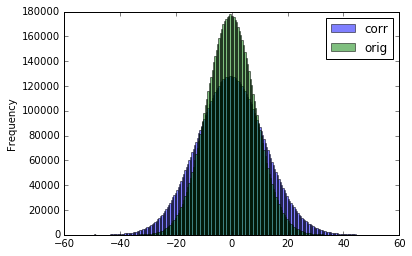

In [4]:
im1a = im1.getMaskedImage().getImage().getArray()
im1a = im1a[~(np.isnan(im1a)|np.isinf(im1a))]
im2a = im2.getMaskedImage().getImage().getArray()
im2a = im2a[~(np.isnan(im2a)|np.isinf(im2a))]

im1a = im1a[im1a != 0.]
im2a = im2a[im2a != 0.]
im1a, _, _ = scipy.stats.sigmaclip(im1a)
im2a, _, _ = scipy.stats.sigmaclip(im2a)
print 'UNCORRECTED:', dit.computeClippedImageStats(im1a)
print 'CORRECTED:  ', dit.computeClippedImageStats(im2a)
print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]
print scipy.stats.describe(im1a)
print scipy.stats.describe(im2a)

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)

0.348901792193
0.0754601074699


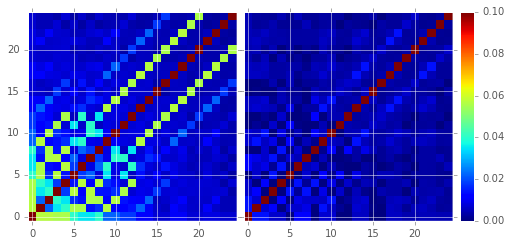

In [8]:
im1a = im1.getMaskedImage().getImage().getArray()
im1a[np.isnan(im1a)|np.isinf(im1a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im1a)
im1a[(im1a < low)|(im1a > upp)] = 0.
cov1 = dit.computePixelCovariance(im1a)

im2a = im2.getMaskedImage().getImage().getArray()
im2a[np.isnan(im2a)|np.isinf(im2a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im2a)
im2a[(im2a < low)|(im2a > upp)] = 0.
cov2 = dit.computePixelCovariance(im2a)

dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.1), cmap=None)

True
1.99417145453 2.00832492924
1.00014561851 1.0
(14, 14) (14, 14)


DescribeResult(nobs=841, minmax=(-0.0062803954101793187, 0.0075814009772423377), mean=1.7314923478957832e-07, variance=8.0208127574460693e-07, skewness=1.701942030161904, kurtosis=28.68071960237077)

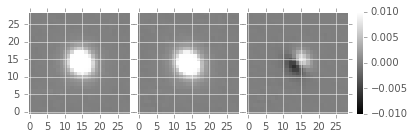

In [6]:
print im2.hasPsf()
im1_psf = im1.getPsf().computeImage().getArray()
im2_psf = im2.getPsf().computeImage().getArray()
print im1.getPsf().computeShape().getDeterminantRadius(), im2.getPsf().computeShape().getDeterminantRadius()
print im1_psf.sum(), im2_psf.sum()
print np.unravel_index(im1_psf.argmax(), im1_psf.shape), np.unravel_index(im2_psf.argmax(), im2_psf.shape)
dit.plotImageGrid((im1.getPsf().computeImage().getArray(), im2_psf, 
                   im1.getPsf().computeImage().getArray() - im2_psf), imScale=2., clim=(-0.01,0.01))
scipy.stats.describe(im1.getPsf().computeImage().getArray() - im2_psf, None)

Here we note that the variance planes are not updated correctly...

UNCORRECTED: (66.898842, 2.5332913)
CORRECTED:   (66.898842, 2.5332913)
EXPECTED:    11.5671
7520808 7520808
DescribeResult(nobs=7520808, minmax=(56.53104, 77.36792), mean=66.937592, variance=6.7996731, skewness=0.24679702520370483, kurtosis=0.1916547975889058)
DescribeResult(nobs=7520808, minmax=(56.53104, 77.36792), mean=66.937592, variance=6.7996731, skewness=0.24679702520370483, kurtosis=0.1916547975889058)


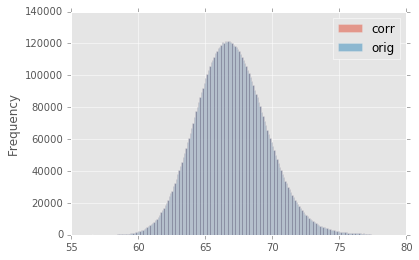

In [7]:
im1a = im1.getMaskedImage().getVariance().getArray()
im1a = im1a[~(np.isnan(im1a)|np.isinf(im1a))]
im2a = im2.getMaskedImage().getVariance().getArray()
im2a = im2a[~(np.isnan(im2a)|np.isinf(im2a))]

im1a = im1a[im1a != 0.]
im2a = im2a[im2a != 0.]
im1a, _, _ = scipy.stats.sigmaclip(im1a)
im2a, _, _ = scipy.stats.sigmaclip(im2a)
print 'UNCORRECTED:', dit.computeClippedImageStats(im1a)
print 'CORRECTED:  ', dit.computeClippedImageStats(im2a)
print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]
print scipy.stats.describe(im1a)
print scipy.stats.describe(im2a)

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)